Bogazici-SWE546-Spring2016 Final Project - Mustafa Atik

## Bike sharing demand competition
I am just a beginner to kaggle competitions. After reading a few posts dealing with the famous titanic data, I felt confident to try to solve a problem on my own. Bike sharing problem is also famous but this time, I will not read the articles about it. After I am done with this problem, surely I will take a look at them. 

### Forecast use of a city bikeshare system
> Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

> The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


In this problem, you are asked to predict bike rental demand in Washington D.C. by using the historical data. Since you will try to predict the demand which is a continuous number, this is a regression problem, not a classification. In titanic competition, you are asked to predict whether a given person can survive or not;  obviously, this is a classification task.

I assume you are familiar with python, and the popular libraries such as pandas, seaborn, pyplot, numpy or even sklearn.

In [20]:
from IPython.core import display
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [2]:
def readCsv(name):
    df = pd.read_csv("data/bike-sharing/{}.csv".format(name), parse_dates=["datetime"])
    df["year"] = pd.DatetimeIndex(df['datetime']).year
    df["month"] = pd.DatetimeIndex(df['datetime']).month
    df["hour"] = pd.DatetimeIndex(df['datetime']).hour
    df["dayofweek"] = pd.DatetimeIndex(df['datetime']).dayofweek
    if "count" in df.columns:
        df["count"] = np.log(df["count"] + 1)
    return df

df = readCsv("train")
df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
6168,2012-02-13 06:00:00,1,0,1,1,4.10,5.305,54,15.0013,1,71,4.290459,2012,2,6,0
7800,2012-06-05 09:00:00,2,0,1,2,21.32,25.000,72,16.9979,50,285,5.817111,2012,6,9,1
6767,2012-03-19 06:00:00,1,0,1,1,18.86,22.725,88,8.9981,2,118,4.795791,2012,3,6,0
9649,2012-10-06 10:00:00,4,0,0,1,25.42,30.305,69,19.0012,198,341,6.291569,2012,10,10,5
4281,2011-10-10 10:00:00,4,1,0,1,22.96,26.515,73,11.0014,107,158,5.583496,2011,10,10,0


### Field descriptions 
```
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 
  1: Clear, Few clouds, Partly cloudy, Partly cloudy 
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 16 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null float64
year          10886 non-null int32
month         10886 non-null int32
hour          10886 non-null int32
dayofweek     10886 non-null int32
dtypes: datetime64[ns](1), float64(4), int32(4), int64(7)
memory usage: 1.2 MB


In [4]:
def exploreUnivariate(feature):
    print "\n-----------------------\nFEATURE: {}\n".format(feature.name)
    print feature.describe()
    sns.distplot(feature)
    plt.show()


-----------------------
FEATURE: season

count    10886.000000
mean         2.506614
std          1.116174
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: season, dtype: float64


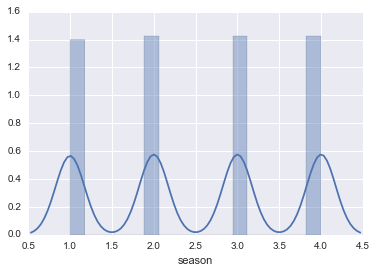


-----------------------
FEATURE: holiday

count    10886.000000
mean         0.028569
std          0.166599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: holiday, dtype: float64


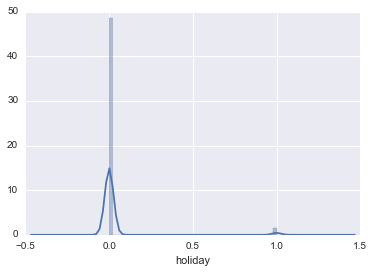


-----------------------
FEATURE: workingday

count    10886.000000
mean         0.680875
std          0.466159
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: workingday, dtype: float64


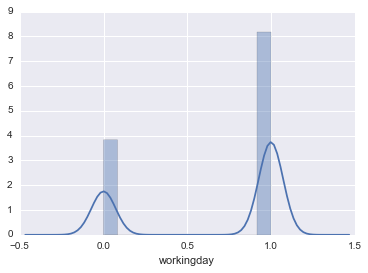


-----------------------
FEATURE: weather

count    10886.000000
mean         1.418427
std          0.633839
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: weather, dtype: float64


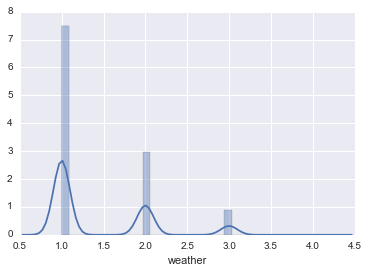


-----------------------
FEATURE: temp

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


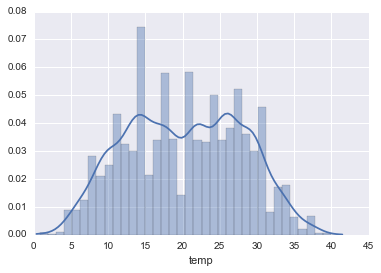


-----------------------
FEATURE: atemp

count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64


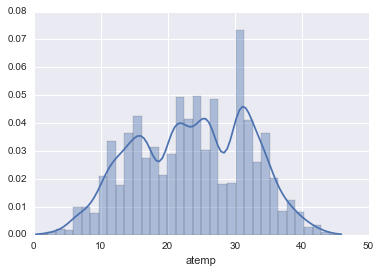


-----------------------
FEATURE: humidity

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64


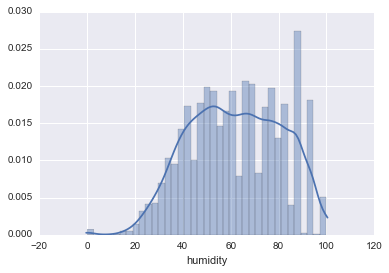


-----------------------
FEATURE: windspeed

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


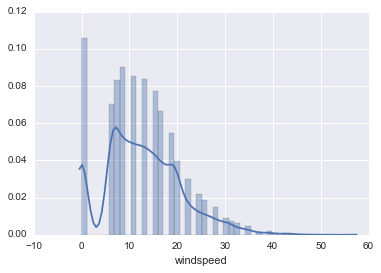


-----------------------
FEATURE: casual

count    10886.000000
mean        36.021955
std         49.960477
min          0.000000
25%          4.000000
50%         17.000000
75%         49.000000
max        367.000000
Name: casual, dtype: float64


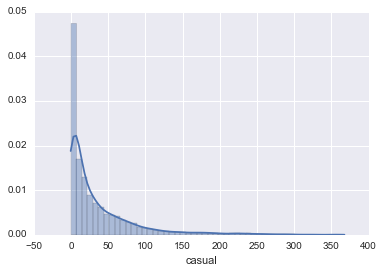


-----------------------
FEATURE: registered

count    10886.000000
mean       155.552177
std        151.039033
min          0.000000
25%         36.000000
50%        118.000000
75%        222.000000
max        886.000000
Name: registered, dtype: float64


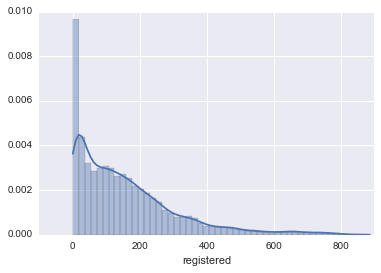


-----------------------
FEATURE: count

count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64


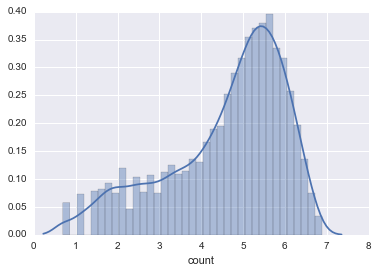


-----------------------
FEATURE: year

count    10886.000000
mean      2011.501929
std          0.500019
min       2011.000000
25%       2011.000000
50%       2012.000000
75%       2012.000000
max       2012.000000
Name: year, dtype: float64


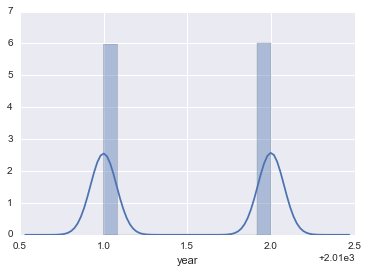


-----------------------
FEATURE: month

count    10886.000000
mean         6.521495
std          3.444373
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


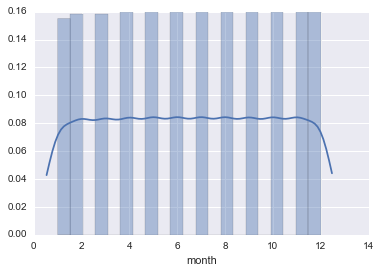


-----------------------
FEATURE: hour

count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64


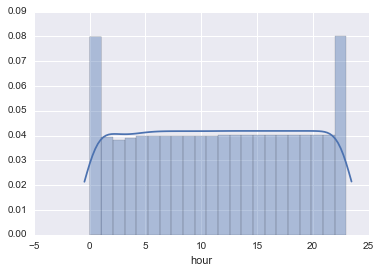


-----------------------
FEATURE: dayofweek

count    10886.000000
mean         3.013963
std          2.004585
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: dayofweek, dtype: float64


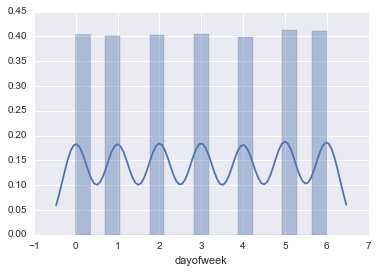

In [5]:
for c in df.columns:
    if c == "datetime":
        continue
    exploreUnivariate(df[c])

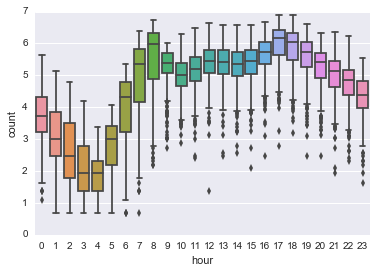

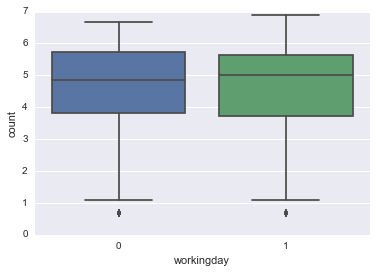

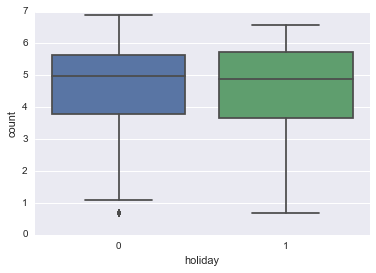

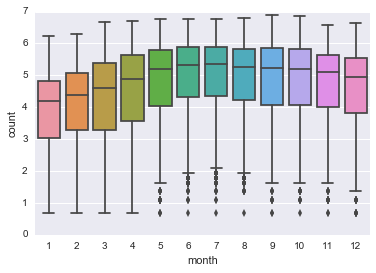

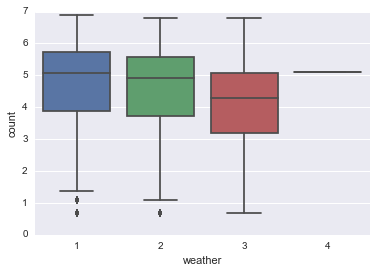

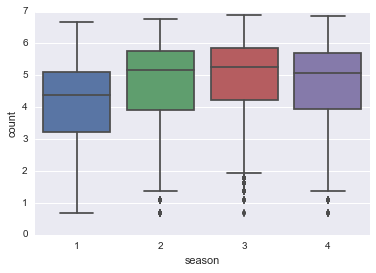

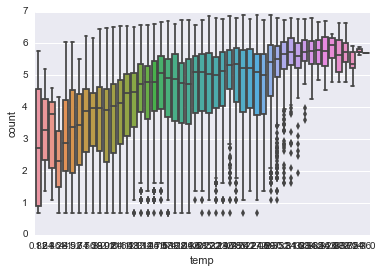

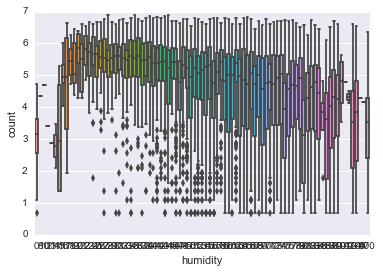

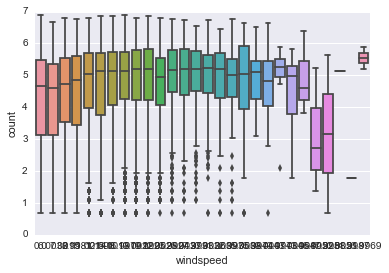

In [6]:
#days_in_month", "dayofweek
cols = [
    "hour", "workingday", "holiday", "month", 
    "weather", "season", "temp", "humidity", "windspeed"]
for i in cols:
    sns.boxplot(x=i, y="count", data=df)
    plt.show()

### Inferences
1. count is high between 6am and 8pm, especially at 7-8 and 17-18
2. count is low on weekends
3. count is high from March to November
4. count is high when the season is 2 and 3
5. count is high when temp is higher than 10 and lower than 40

## Constructing an estimator

First, data is split into two sets as `training set` and `test set`.

In [7]:
X = df[cols]
y = df["count"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X,y, test_size=0.2, random_state=0)
print("traing set: ", X_train.shape, y_train.shape)
print("test set: ", X_test.shape, y_test.shape)

('traing set: ', (8708, 9), (8708,))
('test set: ', (2178, 9), (2178,))


### Choosing the right regressor

In [8]:
def calcError(clf, x_test):
    y_hat = clf.predict(X_test)
    return np.sum(np.sqrt(np.power(np.mat(y_test) - np.mat(y_hat), 2)))

### Evaluation 
To evaluate proposed regressors, R² score, the coefficient of determination method is used. http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination
$$
R^2(y, {\hat{y}}) = 1 - \frac{
\sum_{i=1}^{n=samples} (y_i - \hat{y_i})^2
}{
\sum_{i=1}^{n=samples} (y_i - \bar{y})^2
}
$$

#### Support Vector Regressor

In [9]:
clf = svm.SVR(kernel="rbf", C=6, gamma=.02)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.79381930861656336

#### Random Forest Regressor
ID3 Algorithm -- Michael Crawford, 
http://www.saedsayad.com/decision_tree.htm

In [10]:
X = df[cols]
y = df["count"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X,y, test_size=0.2, random_state=0)

clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.90984494885776079

We can compare random forest regressor(rfr) and svm regressor by looking at their scores. The random forest regressor looks like far better than the svm regressor. So, I choose rfr.

### Finding the optimum parameters for randomforest regressor
To fine tune our randomforest regressor, we find the optimum parameters through grid searching. For each combination of parameters, a new instance of randomforest regressor will be created with that parameter set and its score will be calculated automatically. After grid searching, it is easy to find the best parameter combination to pass to our regressor.

In [11]:
param_grid = [
    {"n_estimators": [2, 5, 10, 15, 20, 100], "bootstrap": [False, True]}
]
clf = GridSearchCV(
    RandomForestRegressor(), param_grid=param_grid, cv=5).fit(X_train, y_train)

In [12]:
clf.grid_scores_

[mean: 0.85461, std: 0.00366, params: {'n_estimators': 2, 'bootstrap': False},
 mean: 0.85688, std: 0.00528, params: {'n_estimators': 5, 'bootstrap': False},
 mean: 0.85758, std: 0.00487, params: {'n_estimators': 10, 'bootstrap': False},
 mean: 0.85732, std: 0.00487, params: {'n_estimators': 15, 'bootstrap': False},
 mean: 0.85818, std: 0.00452, params: {'n_estimators': 20, 'bootstrap': False},
 mean: 0.85827, std: 0.00494, params: {'n_estimators': 100, 'bootstrap': False},
 mean: 0.87826, std: 0.00511, params: {'n_estimators': 2, 'bootstrap': True},
 mean: 0.90554, std: 0.00250, params: {'n_estimators': 5, 'bootstrap': True},
 mean: 0.91342, std: 0.00208, params: {'n_estimators': 10, 'bootstrap': True},
 mean: 0.91523, std: 0.00280, params: {'n_estimators': 15, 'bootstrap': True},
 mean: 0.91605, std: 0.00250, params: {'n_estimators': 20, 'bootstrap': True},
 mean: 0.91991, std: 0.00270, params: {'n_estimators': 100, 'bootstrap': True}]

As shown above, the optimum paramet set is `{n_estimators:100, bootstrap:True}`

### Preparing the final regressor and testing it

In [15]:
clf = RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=20)
clf.fit(X, y)
print "score: ", clf.score(X_test, y_test)

i = 22
y_hat = clf.predict(X_train[i:i+1])
print("actual:{} , predicted:{}".format(int(y_train[i:i+1]), y_hat))

score:  0.98712586999
actual:6 , predicted:[ 6.19752345]


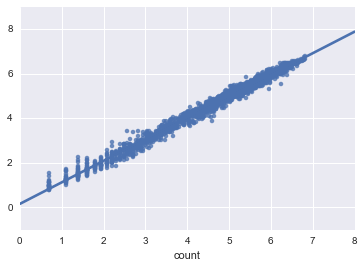

In [19]:
sns.regplot(x=y_test, y=clf.predict(X_test))

### Making prediction on the test data

In [67]:
test_df = readCsv("test")
result = pd.concat([
        test_df["datetime"],
        pd.DataFrame(np.exp(clf.predict(test_df[cols])))
    ], axis=1, join='inner')
result.columns = ["datetime", "count"]
result.head(10)

,datetime,count
0,2011-01-20 00:00:00,40.271258
1,2011-01-20 01:00:00,15.807444
2,2011-01-20 02:00:00,6.116351
3,2011-01-20 03:00:00,7.137744
4,2011-01-20 04:00:00,8.547666
5,2011-01-20 05:00:00,34.937701
6,2011-01-20 06:00:00,118.945244
7,2011-01-20 07:00:00,389.747271
8,2011-01-20 08:00:00,651.526031
9,2011-01-20 09:00:00,293.013254


## A better approach: predicting month by month (not completed yet)

In [64]:
uniqueMonths = test_df["month"].unique()
uniqueYears = test_df["year"].unique()
result = []
for year in uniqueYears:
    for m in uniqueMonths:
        print "month ", year, m
        
        date_condition = (df["month"] == m) & (df["year"] == year )
        X = df[date_condition][cols]
        y = df[date_condition]["count"]
        
        date_condition = (test_df["month"] == m) & (test_df["year"] == year )
        q = test_df[date_condition][cols]

        clf = RandomForestRegressor(n_estimators=200)
        clf.fit(X, y)
        result.append(clf.predict(q))

month  2011 1
month  2011 2
month  2011 3
month  2011 4
month  2011 5
month  2011 6
month  2011 7
month  2011 8
month  2011 9
month  2011 10
month  2011 11
month  2011 12
month  2012 1
month  2012 2
month  2012 3
month  2012 4
month  2012 5
month  2012 6
month  2012 7
month  2012 8
month  2012 9
month  2012 10
month  2012 11
month  2012 12


In [619]:
result = pd.concat([
        test_df["datetime"],
        pd.DataFrame(result)
    ], axis=1, join='inner')
result.columns = ["datetime", "count"]
result.head(10)

,datetime,count
0,2011-01-20 00:00:00,6.991726
1,2011-01-20 01:00:00,6.257386
2,2011-01-20 02:00:00,5.872800
3,2011-01-20 03:00:00,3.270695
4,2011-01-20 04:00:00,2.840367
5,2011-01-20 05:00:00,3.559689
6,2011-01-20 06:00:00,26.462941
7,2011-01-20 07:00:00,81.220191
8,2011-01-20 08:00:00,163.667520
9,2011-01-20 09:00:00,106.090600
